# Validate parquet files

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.utils import get_spark

spark = get_spark()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 20:44:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/03 20:44:26 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/parquet_files

Wed Apr  3 20:44:29 UTC 2024
gs://dsgt-clef-plantclef-2024/data/parquet_files/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_1/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2022_web_training_images_4/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_test/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized/
gs://dsgt-clef-plantclef-2024/data/parquet_files/PlantCLEF2024_training_cropped_resized_v2/


In [4]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/parquet_files/"
train = "PlantCLEF2024_training_cropped_resized_v2"
test = "PlantCLEF2024_test"

# Define the GCS path to the Train parquet file
train_gcs_path = f"{gcs_path}{train}"
test_gcs_path = f"{gcs_path}{test}"

# Read the Parquet file into a DataFrame
train_df = spark.read.parquet(train_gcs_path)
test_df = spark.read.parquet(test_gcs_path)

# Show the data
train_df.show(n=5)
test_df.show(n=5)

+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+--------------------+
|          image_name|                path| organ|species_id|    obs_id|             license|partner|              author|altitude|     latitude|    longitude|gbif_species_id|             species|     genus|       family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|                data|
+--------------------+--------------------+------+----------+----------+--------------------+-------+--------------------+--------+-------------+-------------+---------------+--------------------+----------+-------------+--------+-----------+--------------------+--------------------+---------+--------------------+-----------

+--------------------+--------------------+--------------------+
|                path|          image_name|                data|
+--------------------+--------------------+--------------------+
|/PlantCLEF2024tes...|CBN-Pla-B4-201607...|[FF D8 FF E0 00 1...|
|/PlantCLEF2024tes...|CBN-Pla-D3-201308...|[FF D8 FF E0 00 1...|
|/PlantCLEF2024tes...|CBN-PdlC-E4-20150...|[FF D8 FF E0 00 1...|
|/PlantCLEF2024tes...|CBN-Pla-F5-201509...|[FF D8 FF E0 00 1...|
|/PlantCLEF2024tes...|CBN-Pla-D1-201807...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



### train images

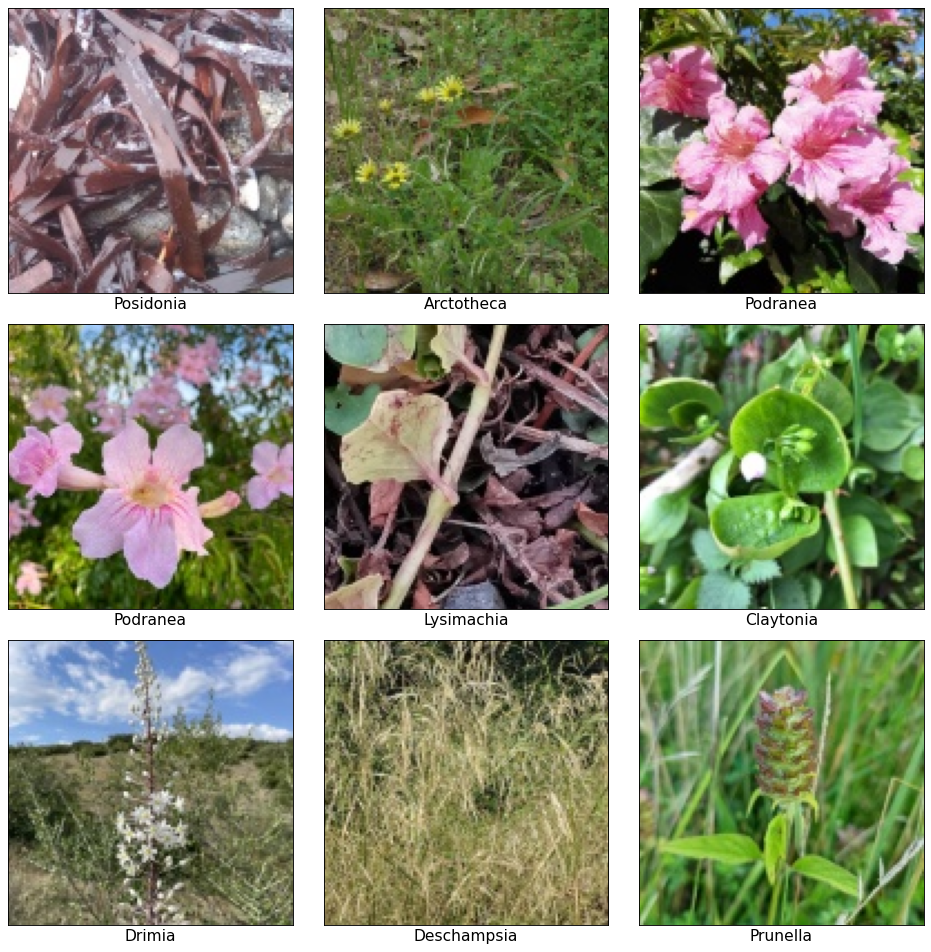

In [5]:
from plantclef.plotting import plot_images_from_binary

# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = train_df.limit(rows * cols).collect()
image_data_list = [row["data"] for row in subset_df]
binomial_names = [row["genus"] for row in subset_df]

# Display the images in a grid with binomial names
plot_images_from_binary(image_data_list, binomial_names, grid_size=(3, 3))

In [6]:
train_df.count()

1408033

### test images

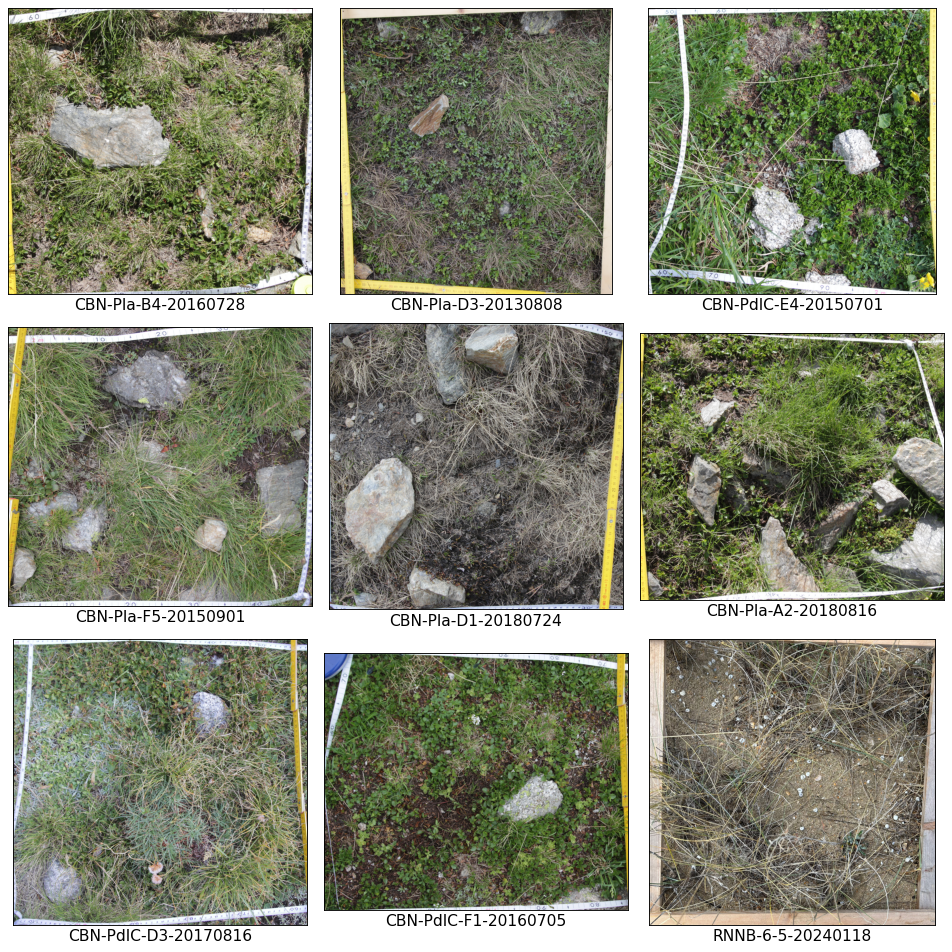

In [7]:
# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = test_df.limit(rows * cols).collect()
image_data_list = [row["data"] for row in subset_df]
image_names = [row["image_name"].replace(".jpg", "") for row in subset_df]

# Display the images in a grid with binomial names
plot_images_from_binary(image_data_list, image_names, grid_size=(3, 3))

In [8]:
test_df.count()

1695

### embeddings

In [9]:
# Get list of stored filed in cloud bucket
root = "gs://dsgt-clef-plantclef-2024"
! date
! gcloud storage ls {root}/data/process/

Wed Apr  3 20:46:15 UTC 2024
gs://dsgt-clef-plantclef-2024/data/process/subset_training_cropped_resized_v2/
gs://dsgt-clef-plantclef-2024/data/process/training_cropped_resized_v2/


In [10]:
# Path and dataset names
gcs_path = "gs://dsgt-clef-plantclef-2024/data/process"
emb_train = "subset_training_cropped_resized_v2/dino/data"

# Define the GCS path to the Train parquet file
emb_gcs_path = f"{gcs_path}/{emb_train}"

# Read the Parquet file into a DataFrame
emb_df = spark.read.parquet(emb_gcs_path)

# Show the data
emb_df.show(n=5, truncate=50)

+--------------------------------------------+----------+--------------------------------------------------+
|                                  image_name|species_id|                                    dino_embedding|
+--------------------------------------------+----------+--------------------------------------------------+
|2fb34c40832bffad3b827eb785ab3fa06f218cd3.jpg|   1361703|[-1.4597739, 0.30644557, 0.6940068, -0.86780685...|
|38da078be8660b7721df5f02c8480df8a74d0057.jpg|   1355927|[-1.5109739, -0.23676546, -1.7989993, -1.358710...|
|242f3c45100ec51fcc2a212f18ad9e552be7d1ed.jpg|   1361703|[-0.7212492, 0.665451, 0.5151086, 1.3082049, -1...|
|be958f8386bd7b19a9488e2b4c9e847845b86b86.jpg|   1361703|[1.2791156, 0.37928835, -1.5690016, -0.00115071...|
|7e91e5a4c7780887eff87f3b5216a3b5c2389d05.jpg|   1355927|[-2.2752292, 1.7813959, -1.1109318, 1.2797651, ...|
+--------------------------------------------+----------+--------------------------------------------------+
only showing top 5 

In [11]:
# Join with train_df to get species names
joined_emb_df = emb_df.join(train_df, "image_name", "inner").select(
    [
        emb_df["image_name"],
        train_df["species"],
        emb_df["species_id"],
        emb_df["dino_embedding"],
    ]
)
joined_emb_df.show(n=5)

+--------------------+--------------------+----------+--------------------+
|          image_name|             species|species_id|      dino_embedding|
+--------------------+--------------------+----------+--------------------+
|105e4f15c762b9c1a...|Arctotheca calend...|   1355927|[-0.582438, -0.30...|
|2b7b871b5572ff46e...|Arctotheca calend...|   1355927|[0.26519057, -0.9...|
|2fb34c40832bffad3...|Posidonia oceanic...|   1361703|[-1.4597739, 0.30...|
|621e686326c070ba8...|Posidonia oceanic...|   1361703|[-1.4104865, -0.2...|
|626237693bbfb18aa...|Posidonia oceanic...|   1361703|[-0.6517539, -3.1...|
+--------------------+--------------------+----------+--------------------+
only showing top 5 rows



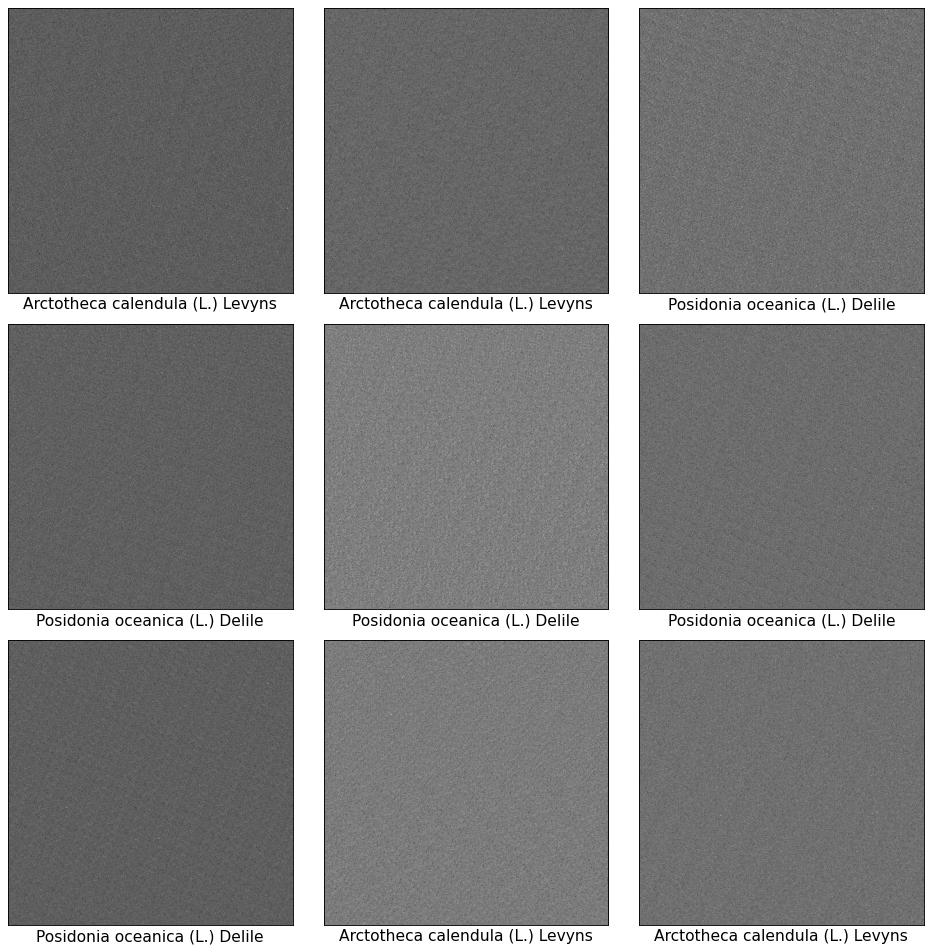

In [12]:
from plantclef.plotting import plot_images_from_embeddings

# Collect binary image data from DataFrame
rows, cols = 3, 3
subset_df = joined_emb_df.limit(rows * cols).collect()
image_data_list = [row["dino_embedding"] for row in subset_df]
image_names = [row["species"] for row in subset_df]

# Plot image embeddings
plot_images_from_embeddings(image_data_list, image_names, grid_size=(3, 3))